# Country coverage
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to test how many countries would be defined as having peaked by now using the statistical test that we identify here

## Load packages

In [1]:
%reload_ext autoreload
%autoreload 2

In [25]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_indexing as pix
from pandas_indexing import *


## Fossil co2 implementation

### Basic analysis
- Testing whether EU has peaked to start

In [7]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
gcb_data = pd.read_csv('../data/processed/gcb_hist_co2.csv',index_col=[0,1,2,3])
gcb_data.columns = gcb_data.columns.astype(int)
gcb_data = gcb_data.loc[~gcb_data.loc[:,1990:].isnull().any(axis=1)]
gcb_data.head()

,,,,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
region,region_name,variable,unit,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.170309,9.791093,9.067598,9.867969,10.818048,11.081621,11.888066,10.954852,11.435509,11.999400
ALB,Albania,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.988089,4.676772,4.592142,5.262315,4.881108,4.822475,5.018729,4.853654,4.955267,4.975772
DZA,Algeria,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,134.946313,142.940027,142.424820,148.556267,154.901228,161.620464,152.384283,164.583676,170.122012,164.922210
AND,Andorra,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.461664,0.465328,0.468992,0.465328,0.494640,0.483648,0.373728,0.407563,0.422606,0.428915
AGO,Angola,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.214294,18.170923,15.702233,15.479466,16.188422,14.855367,13.259737,15.264457,16.404896,16.549646


In [52]:
G20_ISOS = ['AUS','ARG','BRA','CAN','CHN','EU27','IND','IDN','JPN','MEX','RUS','SAU','KOR','TUR','GBR','USA','ZAF'] 

In [53]:
likelihood_of_peaking = pd.Series()

#This is time intensive – roughly 1.5 seconds per country
with HiddenPrints():
    for region in G20_ISOS: #list(gcb_data.pix.project('region').index)[:]:
        peak_tester = EmissionsPeakTest()
        peak_tester.load_historical_data(
            'gcb_hist_co2.csv', region=region,year_range = range(1990,2024))
        peak_tester.characterize_noise(method='loess', fraction=0.25,noise_type = 't-dist')
        peak_tester.create_noise_generator()
        peak_tester.set_test_data(
            list(
                peak_tester.historical_data.loc[
                    peak_tester.historical_data.year.isin(range(2014,2024))
                    ].itertuples(index=False, name=None)
            )).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        likelihood_of_peaking.loc[region] = 1 - peak_tester.bootstrap_results['p_value_one_tail']


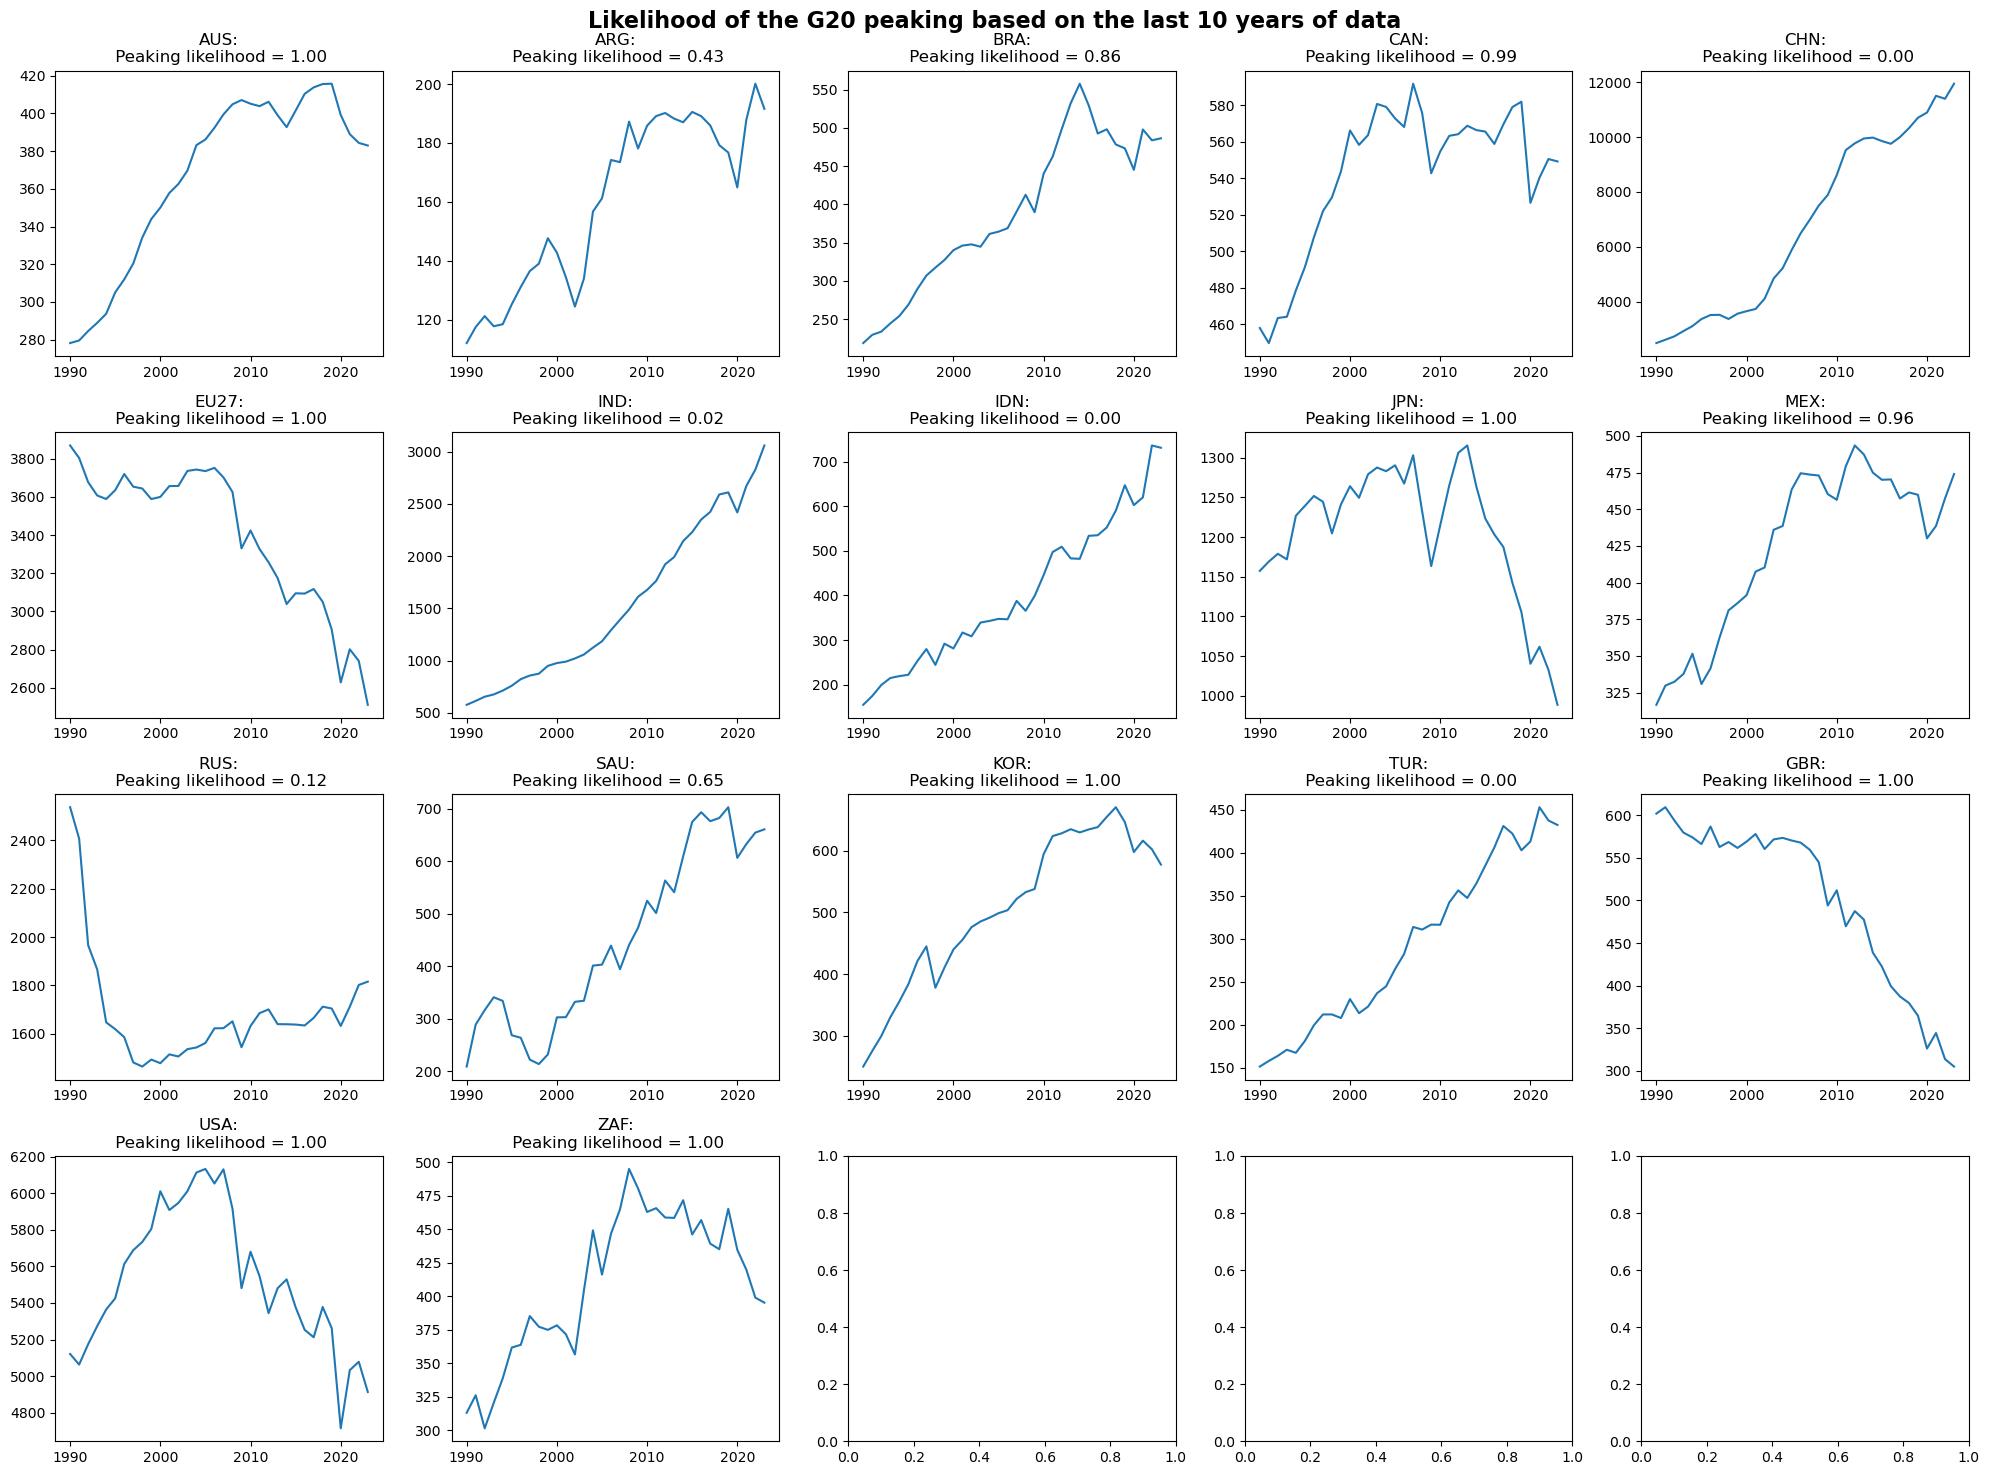

In [67]:
f, axes = plt.subplots(nrows=4,ncols=5,figsize=(20,15))

for count, ax in enumerate(axes.ravel()[:-3]):
    gcb_data.loc[isin(region=G20_ISOS[count]),1990:].T.plot(ax=ax,legend=False)
    ax.set_title(f'{G20_ISOS[count]}:\n Peaking likelihood = {likelihood_of_peaking[G20_ISOS[count]]:.2f}')


f.suptitle('Likelihood of the G20 peaking based on the last 10 years of data', fontweight='bold',fontsize=16)
plt.tight_layout()

## To further explore, work in progress
Looking at whether noise characterisation varies pre- and post- peak for countries

In [95]:
peak_tester.characterize_noise(method='loess',fraction=0.15,noise_type='t-dist')

using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 1.2
Autocorrelation analysis:
  Lag-1 autocorr: -0.097
  Residual σ (post-autocorrelation): 103.8
  Has significant autocorr: False
  Likelihood of autocorr: 0.9457514890199097
Noise characterization complete:
  Method used: loess


In [96]:
year=2023
peak_tester.characterize_noise(method='loess', fraction=0.15*(year-1990)/(2023-1990),noise_type = 't-dist')

using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 1.2
Autocorrelation analysis:
  Lag-1 autocorr: -0.097
  Residual σ (post-autocorrelation): 103.8
  Has significant autocorr: False
  Likelihood of autocorr: 0.9457514890199097
Noise characterization complete:
  Method used: loess


Loaded historical data: 1990-2023
Data points: 34


<Axes: >

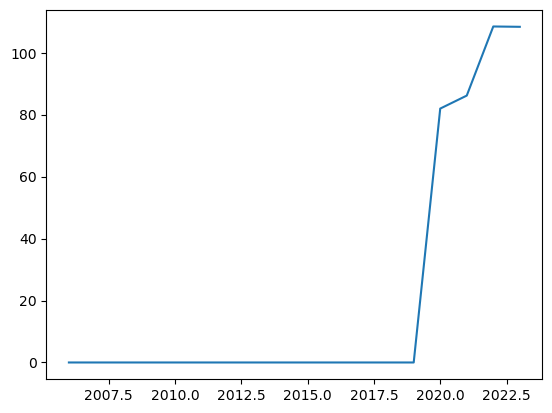

In [97]:
noise_characterisation = pd.Series()

peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', region='USA',year_range = range(1990,2024))
#This is time intensive – roughly 1.5 seconds per country
with HiddenPrints():
    for year in range(2006,2024): #list(gcb_data.pix.project('region').index)[:]:

        peak_tester.characterize_noise(method='loess', ignore_years=range(year,2024), fraction=0.15*(year-1990)/(2023-1990),noise_type = 't-dist')
        noise_characterisation.loc[year] = peak_tester.autocorr_params['sigma_residuals']

noise_characterisation.plot()

In [78]:
noise_characterisation

2006    19.988646
2007    19.867371
2008    19.293563
2009    19.376997
2010    32.690685
2011    46.185725
2012    45.721211
2013    44.876808
2014    47.262805
2015    45.874632
2016    48.443780
2017    48.148732
2018    47.861508
2019    47.422076
2020    49.749418
2021    63.246609
2022    64.692254
2023    64.217597
dtype: float64

In [29]:
likelihood_of_peaking

AFG    0.2022
ALB    0.7425
DZA    0.0000
AND    0.8656
AGO    0.9060
AIA    0.0334
ATG    0.0000
ARG    0.4174
ARM    0.0171
ABW    0.5003
AUS    0.9993
AUT    0.9999
AZE    0.0221
BHS    0.0002
BHR    0.0000
BGD    0.0000
BRB    1.0000
BLR    0.7249
BEL    1.0000
BLZ    0.0016
dtype: float64

In [23]:
likelihood_of_peaking

AFG    0.2084
ALB    0.7405
DZA    0.0001
dtype: float64

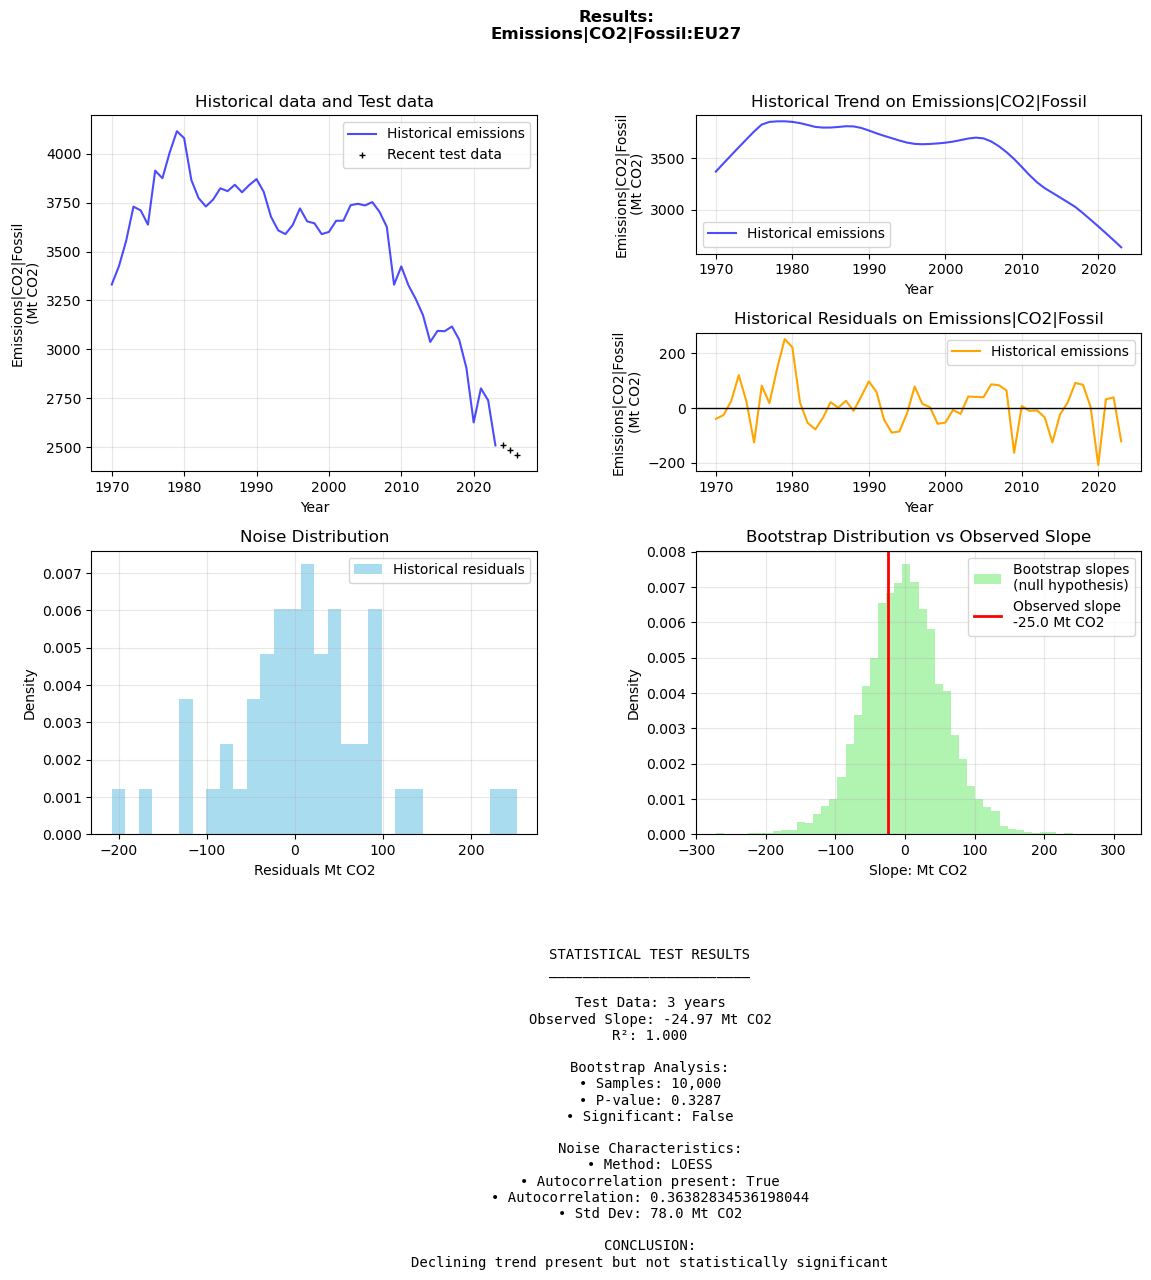

In [12]:
peak_tester.plot_analysis()

### Test impact of adding ignore_years

In [9]:
peak_tester.characterize_noise(method='hp')
peak_tester.characterize_noise(method='hp',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.399
  Residual σ (post-autocorrelation): 462.1
  Has significant autocorr: True
  Likelihood of autocorr: 0.9891095773301503
Noise characterization complete:
  Method used: hp
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.741
  Residual σ (post-autocorrelation): 333.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999999618417601
Noise characterization complete:
  Method used: hp


In [10]:
peak_tester.characterize_noise(method='loess')
peak_tester.characterize_noise(method='loess',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.406
  Residual σ (post-autocorrelation): 468.9
  Has significant autocorr: True
  Likelihood of autocorr: 0.9909892669917686
Noise characterization complete:
  Method used: loess
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.591
  Residual σ (post-autocorrelation): 329.1
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999165983843805
Noise characterization complete:
  Method used: loess


In [11]:
peak_tester.characterize_noise(method='hamilton')
peak_tester.characterize_noise(method='hamilton',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: -0.006
  Residual σ (post-autocorrelation): 628.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.0063212162042093345
Noise characterization complete:
  Method used: hamilton
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.081
  Residual σ (post-autocorrelation): 355.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.32845341857014976
Noise characterization complete:
  Method used: hamilton


### Test impact of changing fraction for LOESS
Fraction is one of the main parameters in LOESS – how much of the time series do you use as the locally weighted regression? 

In [12]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [13]:
noise_params = []
peaking_likelihood = []

with HiddenPrints():
    for frac in np.linspace(0.1,0.9,17):
        (
            peak_tester
            .characterize_noise(method='loess',fraction=frac)
            .create_noise_generator()
        )
        (    peak_tester
            .set_test_data([
                (2025, 37700),
                (2026, 37580), 
                (2027, 37460),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )


        noise_params.append(peak_tester.autocorr_params)
        peaking_likelihood.append(peak_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions on the \nlikelihood that emissions have peaked')

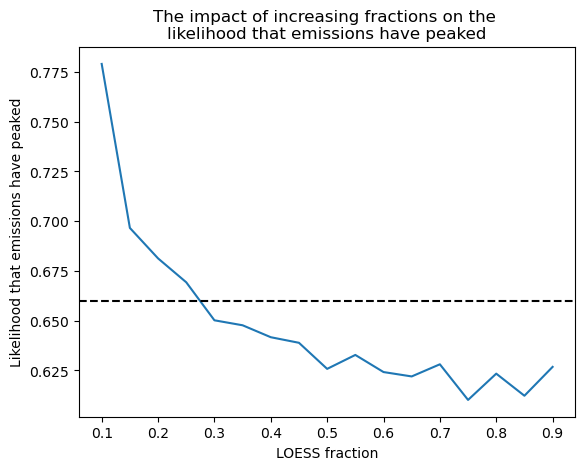

In [14]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[1-s for s in peaking_likelihood])
ax.set_ylabel('Likelihood that emissions have peaked')
ax.set_xlabel('LOESS fraction')
ax.axhline(y=0.66,color='k',ls='--')
ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')

# LOESS fraction of 0.1 ~= 5 year trend, 0.2 ~= 10 trends (with 54 data points)

Text(0.5, 1.0, 'The impact of increasing fractions \n on the estimate of noise')

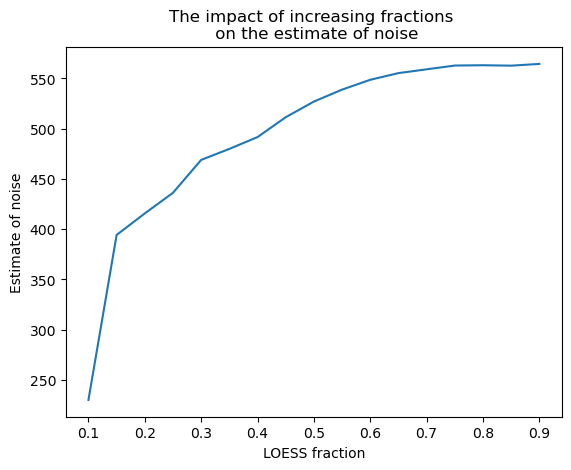

In [15]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[noise_params[i]['sigma_residuals'] for i in range(17)])
ax.set_ylabel('Estimate of noise')
ax.set_xlabel('LOESS fraction')
ax.set_title('The impact of increasing fractions \n on the estimate of noise')

# LOESS fraction of 0.1 ~= 5 year trend, 0.2 ~= 10 trends (with 54 data points)

## Testing impact of different noise distribution types

Loaded historical data: 1970-2014
Data points: 45


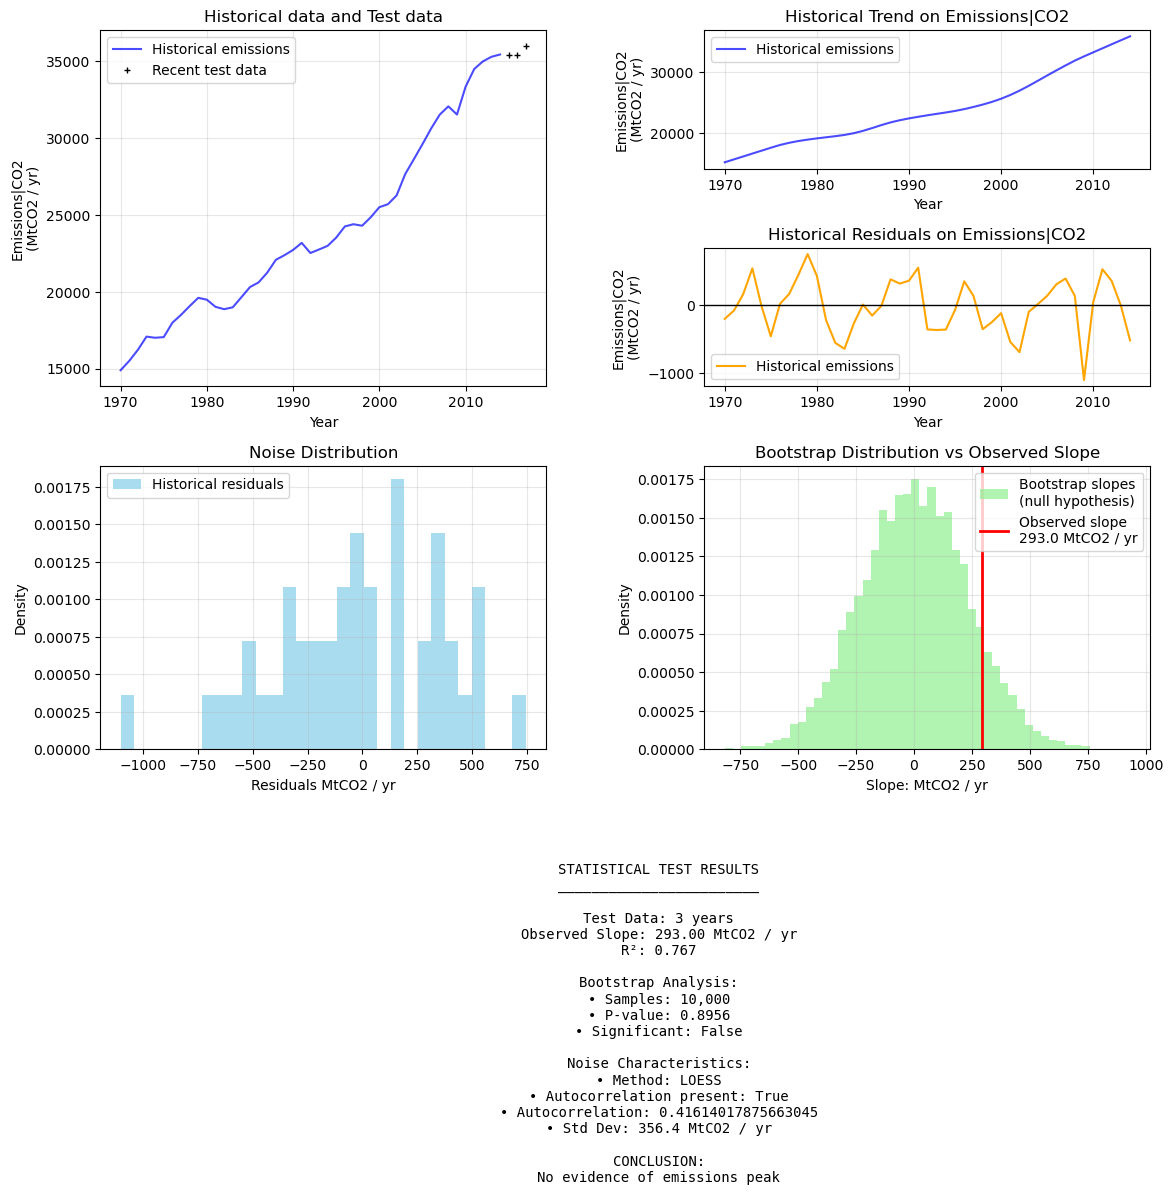

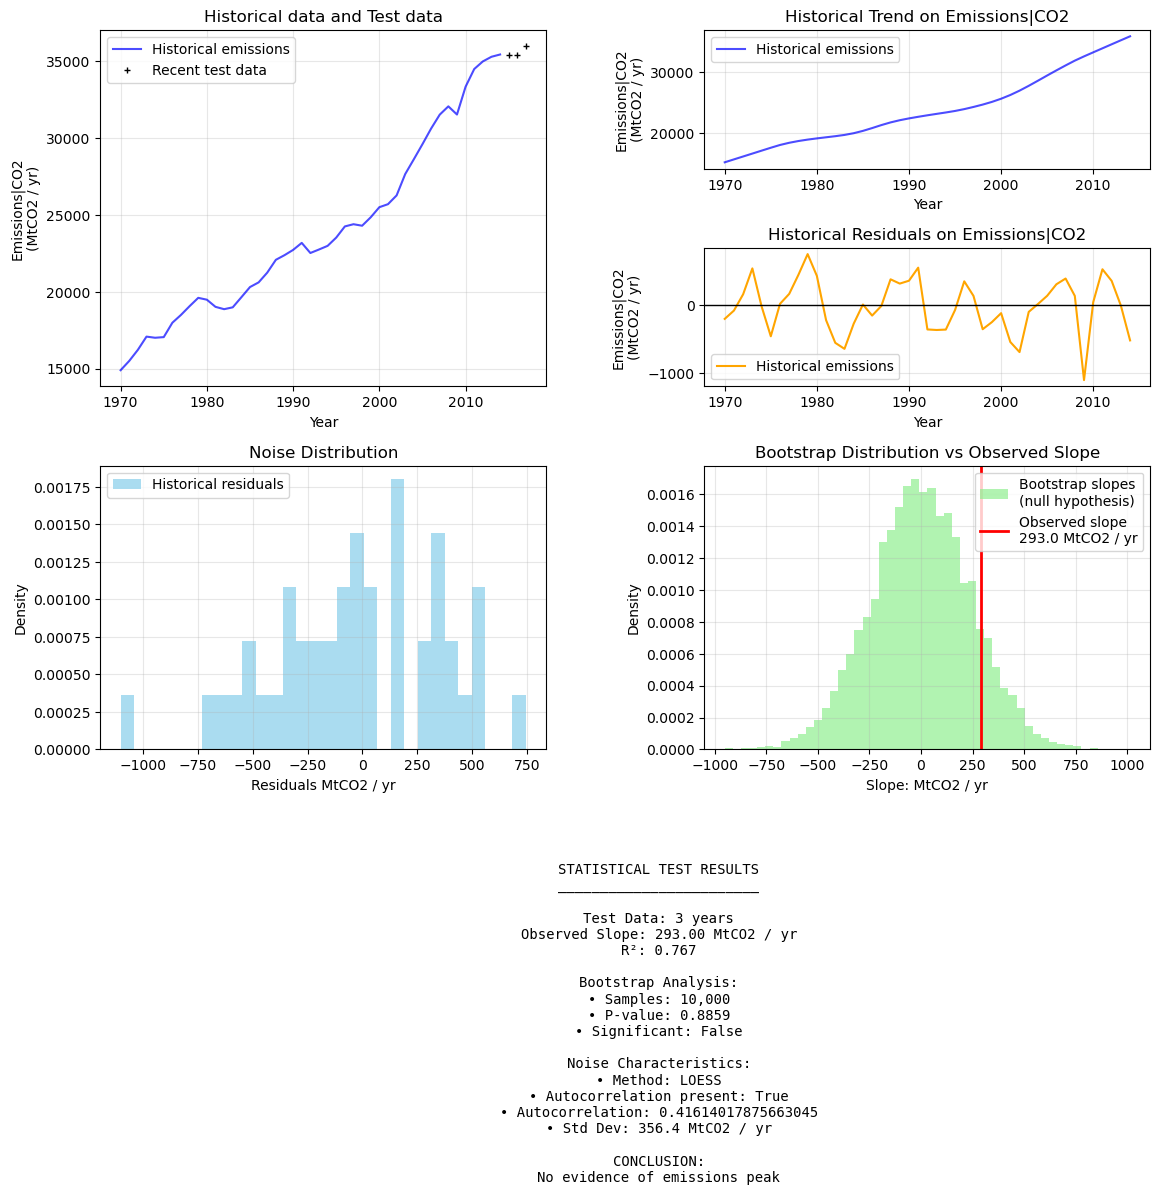

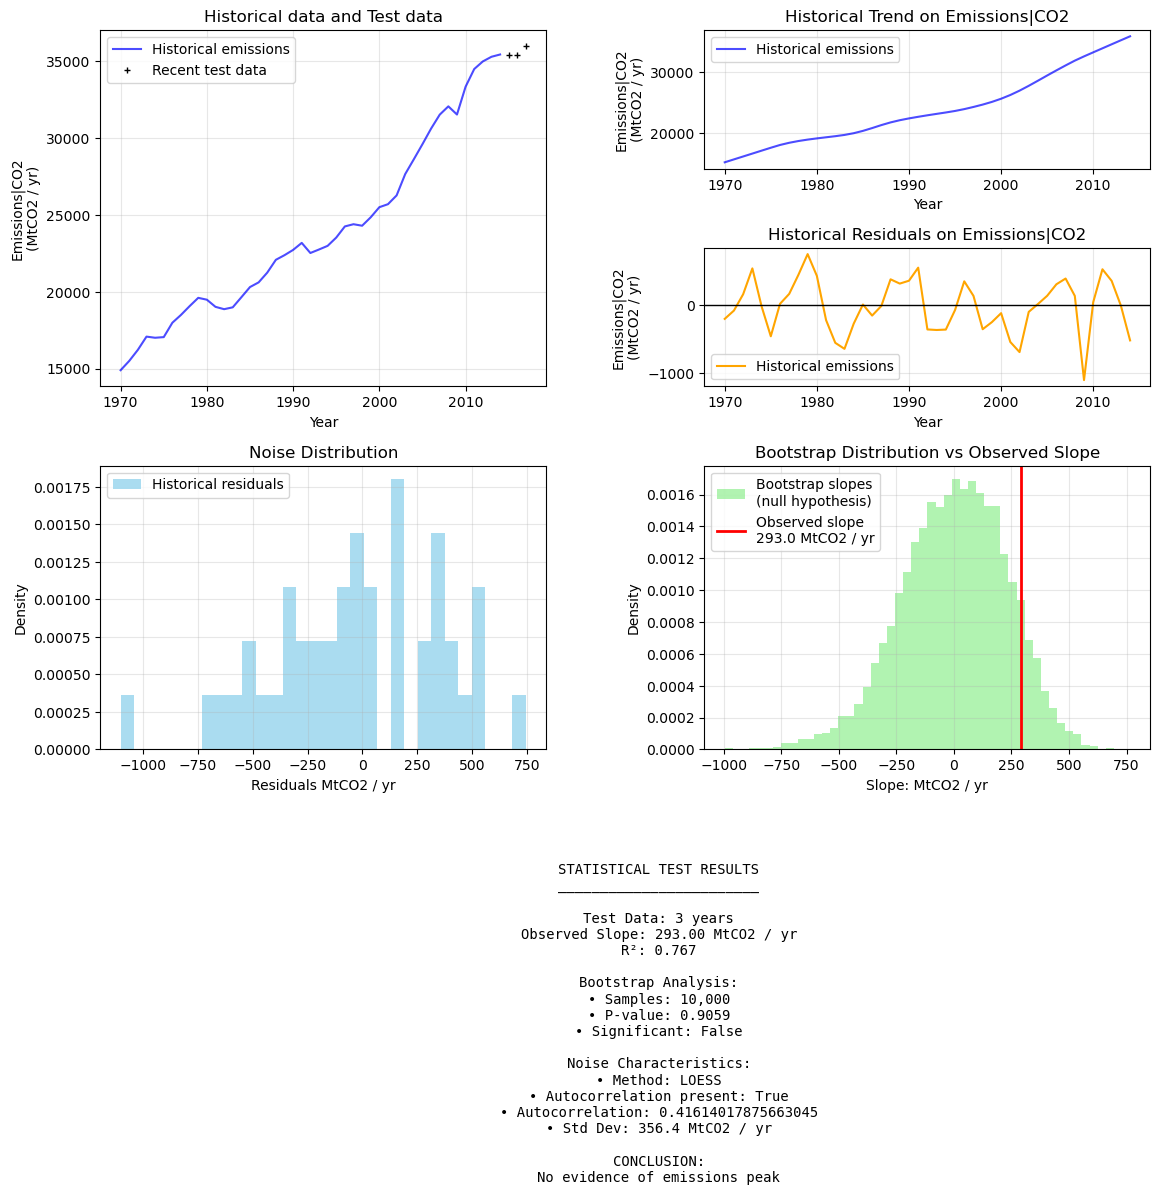

In [25]:
# Testing with data to 2014 and then 2015 and 2016 to see how likely it thinks peaking is - and the answer is not very :)
# t-distribution seems to be the most conservative.
noise_params = []
peaking_likelihood = []
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', year_range = range(1970,2015))

with HiddenPrints():
    for noise_type in ["normal", "t-dist", "empirical"]:
        (
            peak_tester
            .characterize_noise(method='loess',noise_type=noise_type)
            .create_noise_generator()
        )
        (    peak_tester
            .set_test_data([
                (2015, 35404),
                (2016, 35417),
                (2017, 35990)
                # (2017, 35200) # made up value for testing
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )
        peak_tester.plot_analysis()


        noise_params.append(peak_tester.autocorr_params)
        peaking_likelihood.append(peak_tester.bootstrap_results['p_value_one_tail'])
        

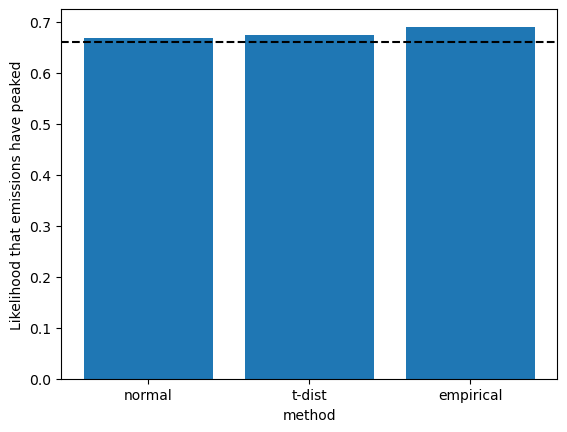

In [17]:
f, ax = plt.subplots()
ax.bar(["normal", "t-dist", "empirical"], [1-s for s in peaking_likelihood])
ax.set_ylabel('Likelihood that emissions have peaked')
ax.set_xlabel('method')
ax.axhline(y=0.66, color='k', ls='--')
# ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')


## Implementation on carbon intensity
Test applying the peak tester to carbon intensity instead, which abstracts out the GDP growth component

In [18]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data(
    'fossil_intensity.csv', year_range = range(1971,2024))

Loaded historical data: 1971-2023
Data points: 53


In [19]:
ci_noise_params = []
ci_peaking_likelihood = []

with HiddenPrints():
    for frac in np.linspace(0.1,0.9,17):
        (
            carbon_intensity_tester
            .characterize_noise(method='loess',fraction=frac)
            .create_noise_generator()
        )
        (    carbon_intensity_tester
            .set_test_data([
                (2025, 37700),
                (2026, 37580), 
                (2027, 37460),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )


        ci_noise_params.append(carbon_intensity_tester.autocorr_params)
        ci_peaking_likelihood.append(carbon_intensity_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions \n on the estimate of noise')

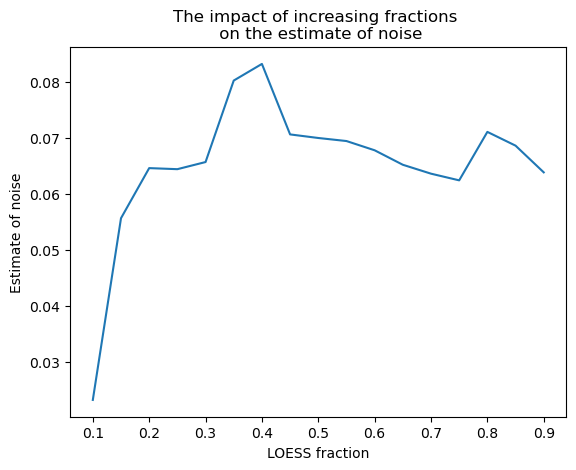

In [20]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[ci_noise_params[i]['sigma_residuals'] for i in range(17)])
ax.set_ylabel('Estimate of noise')
ax.set_xlabel('LOESS fraction')
ax.set_title('The impact of increasing fractions \n on the estimate of noise')

# LOESS fraction of 0.1 ~= 3 year trend, 0.2 ~= 6 trends (with ~30 data points)

Let's assume that GDP is growing at 2% per year over a three year period. Therefore we want to test if carbon intensity is falling more than 2% per year (which would be needed to offset a GDP growth trend)

In [21]:
carbon_intensity_tester.characterize_noise(method='loess',fraction=0.1).create_noise_generator()

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: -0.006
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: False
  Likelihood of autocorr: 0.10318839950836867
Noise characterization complete:
  Method used: loess
Using white noise generator with σ=0.0


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.white_noise_generator(size: int, initial_value: float = 0) -> numpy.ndarray>

In [22]:
ci_2023 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2023,'emissions'].squeeze()

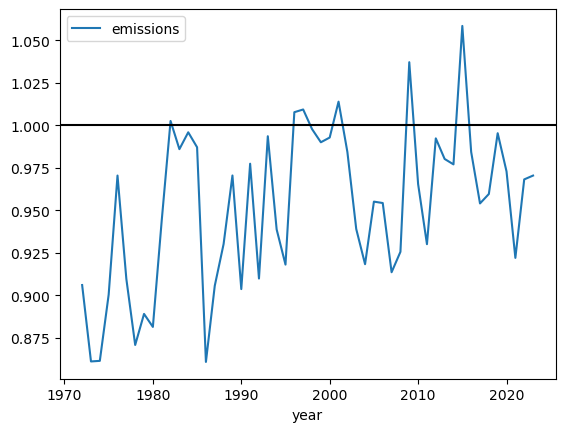

In [34]:
(carbon_intensity_tester.historical_data.set_index('year') / carbon_intensity_tester.historical_data.set_index('year').shift(1)).plot()
ax = plt.gca()
ax.axhline(y=1,color='k')

Test data set: 2025-2027
Test slope: -0.01 kgCO2 / $ (R² = 1.000)
Recent historical trend: -0.01 kgCO2 / $
Running complete bootstrap test...
  Null hypothesis: trend of -0.00706577408 / yr
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.3102
  Significant at α=0.05: False
  Effect size: 0.48 standard deviations


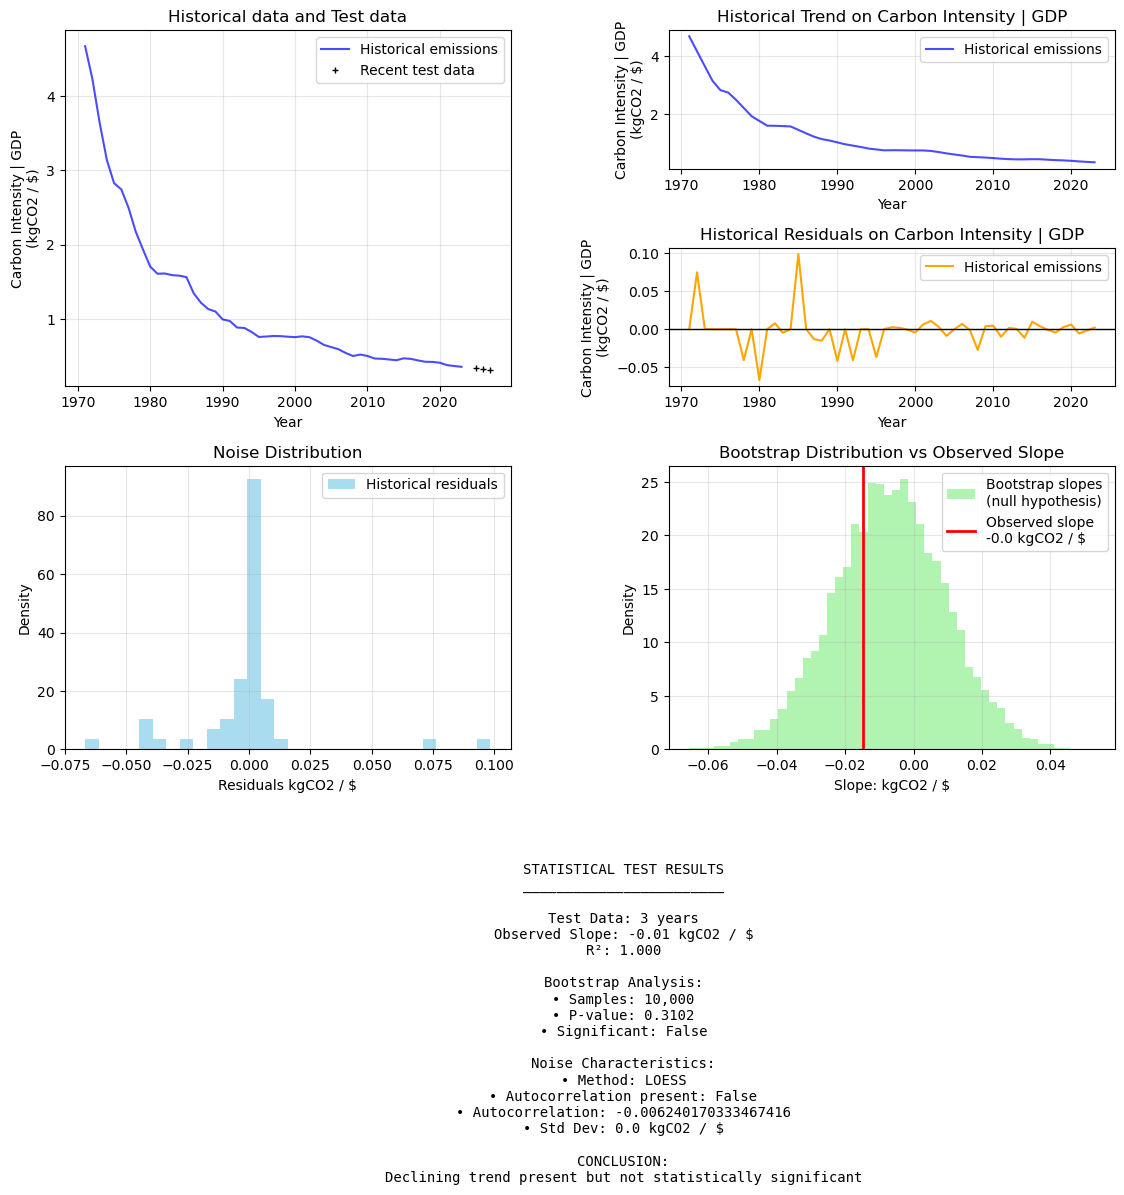

In [23]:

carbon_intensity_tester.set_test_data([
        (2025, ci_2023*0.955),
        (2026, ci_2023*0.955**2), 
        (2027, ci_2023*0.955**3),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2023*-0.02)

carbon_intensity_tester.plot_analysis()